<a href="https://colab.research.google.com/github/KordingLab/Neural_Decoding/blob/classifiers/central_concepts_in_ML_for_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decoding neural activity
_Machine learning for mind reading_

This tutorial introduces concepts that are central to the practice of decoding neural activity using machine learning (or any method). We will make heavy use of our [Python package for neural decoding](https://github.com/KordingLab/Neural_Decoding).

This tutorial accompanies these [lecture slides](https://).

The solutions to the exercises can be found in [this completed Colab](https://colab.research.google.com/drive/1SxXwmTgW2Ro34BQEy91zOXHs9JhMqcBJ).

### Outline

1. Overfitting
2. Crossvalidation
3. Regularization
4. Applying recurrent neural networks
5. What methods work best and when?

## Preliminaries

Import modules and simulate data

In [43]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
from scipy.signal import windows
import pickle
import pathlib as pl
from sklearn import linear_model
from sklearn import model_selection


# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history
from Neural_Decoding.preprocessing_funcs import bin_spikes
from Neural_Decoding.preprocessing_funcs import bin_output

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerCascadeDecoder
from Neural_Decoding.decoders import WienerFilterDecoder
from Neural_Decoding.decoders import DenseNNDecoder
from Neural_Decoding.decoders import SimpleRNNDecoder
from Neural_Decoding.decoders import GRUDecoder
from Neural_Decoding.decoders import LSTMDecoder
from Neural_Decoding.decoders import XGBoostDecoder
from Neural_Decoding.decoders import SVRDecoder

#Turn off deprecation warnings

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# folder='' #ENTER THE FOLDER THAT YOUR DATA IS IN
# folder='/home/jglaser/Data/DecData/' 
folder=pl.Path(r'Z:\Emilio\SuperiorColliculusExperiments\Roller\Batch2_ephys\MC\GAD18\211205_C\ephys_F\\')
#folder=pl.Path(r'Z:\Emilio\Decoding\\')
folder=folder.as_posix()

#with open(folder+'/example_data_s1.pickle','rb') as f:
with open(folder+'/GADi18_decod.pickle','rb') as f:
    #spike_times,vels,unitID,fr,fs,vel_times=pickle.load(f,encoding='latin1') #If using python 3
    neural_data,vels,unitID,fr,fs=pickle.load(f,encoding='latin1') #If using python 3
fs = float(fs)
n_neurons = 59
n_bins_per_trial = 75

### Let's simulate some data

#### Exercise 0: Look at the distribution of neural activity 

Let's gain an intuition for the data. Plot out the average neural activity for each of the two choices. 

Average across trials **and** neurons — we're going to assume they have the same response properties. Then, plot out the averages for trials with a choices of 0 vs a choice of 1.

If you have extra time, overlay the standard deviations.

## 1. Overfitting

<img src='https://cdn-images-1.medium.com/max/1600/1*SBUK2QEfCP-zvJmKm14wGQ.png' />

In common parlance, we call a classifier or regressor 'overfit' when it has learned to explain noise in the training set at the expense of its ability to generalize to new data.

In that one-sentence description, we invoked the concepts of _training set_ and _generalization_. These are absolutely key to any modeling effort, including decoding.

##### Training sets vs. testing sets
You need to train your decoder, obviously, and for that you'll need training data. No one cares how well your decoder works on your training data, though. What we care about is its _performance on data not used for training_.  That is, we are interested in how well your decoder **generalizes** to new data. The only way to rigorously know how well your decoder generalizes is to test it on data not used for training. 

In [62]:
## Fit a decoder using all your data
#Set what part of data should be part of the training/testing/validation sets
#I made the ranges smaller for this example so that the hyperparameter optimization runs faster
training_range=[0.6, 0.7] 
testing_range=[0.7, 0.8]
valid_range=[0.8,0.9]


num_examples=neural_data.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples)))
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples)))
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples)))

#Get training data
X_train=neural_data[training_set,:]
y_train=vels[training_set]

#Get testing data
X_test=neural_data[testing_set,:]
y_test=vels[testing_set]

#Get validation data
X_valid=neural_data[valid_set,:]
y_valid=vels[valid_set]
# We'll predict each decision using all neurons's activity throughout the trials
#X = np.reshape(neural_recordings, (n_trials,-1))

# Naive regression
naive_model = linear_model.LinearRegression()
naive_model.fit(X_train, y_train)
print('Naive model')
print('V',naive_model.score(X_valid, y_valid))
print('T',naive_model.score(X_test, y_test))

# Cross-validation Ridge
bay_ridge_model = linear_model.BayesianRidge(n_iter=500)
bay_ridge_model.fit(X_train, y_train)
print(bay_ridge_model.score(X_valid, y_valid))

# Bayesian ridge
cv_ridge_model = linear_model.RidgeCV(alphas=np.logspace(-5,3,1), cv=10)
cv_ridge_model.fit(X_train, y_train)
print(cv_ridge_model.score(X_valid, y_valid))

# Cross-validation lasso
lasso_model = linear_model.LassoLarsCV(cv=10)
lasso_model.fit(X_train, y_train)
print(lasso_model.score(X_valid, y_valid))

0.4580906012315027
0.6185361114439478
0.4563282411806775
0.45632846613094824
-0.0594075002909753


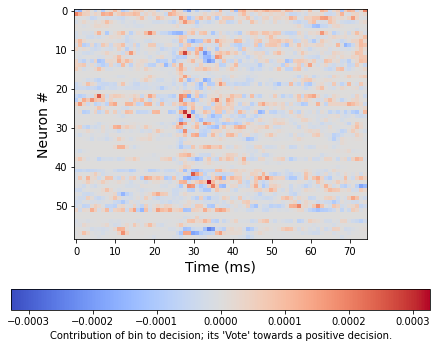

In [56]:
def plot_coefs(fit_model):
  """Makes a nice plot of the coefficients. fit_model is the model instance after fitting."""
  # get the coefficients of your fit
  coefficients = fit_model.coef_.reshape(n_neurons, n_bins_per_trial)
  

  # show them
  plt.figure(figsize = (10,5))
  plt.imshow(coefficients, cmap = 'coolwarm', vmin = -np.max(coefficients), 
                                              vmax = np.max(coefficients))

  #make it pretty
  plt.ylabel("Neuron #", fontsize = 14)
  plt.xlabel("Time (ms)", fontsize = 14)
  plt.colorbar(orientation = 'horizontal', shrink = .6, 
               label="Contribution of bin to decision; its 'Vote' towards a positive decision.")
  plt.tight_layout()
  plt.show()
  
plot_coefs(naive_model)

**Looks great!** 

#### Exercise 1.1: 
Now, suppose you release your decoder in the world. Will it work? Can't be better than perfect, right?

Create some new data and use the `score` function to see the $R^2$ of your model on new data.

In [9]:

new_neural_recordings, new_decisions = generate_neural_data(n_trials, 
                                             n_neurons, n_bins_per_trial)
new_X = np.reshape(new_neural_recordings, (n_trials,-1))


# Now you: score the model on this new data
print("R2 test was",my_naive_model.score(new_X,decisions))

R2 test was -1.5056591955053427


#### Exercise 1.2: 
You may have noticed that we're using linear *regression*, even though we have a classification problem.
It'd be better to use logistic regression. 

Fit and score this logistic regression method using your original data.

Then, also score this method with the new data you just obtained with your R01 funds. (That is, print both the test and train accuracy.)

In [10]:
log_reg = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                          max_iter = 1000)

# fit
log_reg.fit(X, decisions)
# now score on both test and train
print("R2 train was",log_reg.score(X,decisions))
print("R2 test was",log_reg.score(new_X,decisions))

R2 train was 1.0
R2 test was 0.452


Once you've completed that, just run this next cell. 

It shows the coefficients of the fit you just made. Does it match your intuitions? 

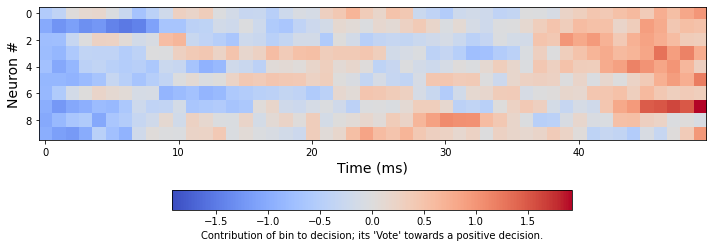

In [11]:

def plot_coefs(fit_model):
  """Makes a nice plot of the coefficients. fit_model is the model instance after fitting."""
  # get the coefficients of your fit
  coefficients = fit_model.coef_.reshape(n_neurons, n_bins_per_trial)
  

  # show them
  plt.figure(figsize = (10,5))
  plt.imshow(coefficients, cmap = 'coolwarm', vmin = -np.max(coefficients), 
                                              vmax = np.max(coefficients))

  #make it pretty
  plt.ylabel("Neuron #", fontsize = 14)
  plt.xlabel("Time (ms)", fontsize = 14)
  plt.colorbar(orientation = 'horizontal', shrink = .6, 
               label="Contribution of bin to decision; its 'Vote' towards a positive decision.")
  plt.tight_layout()
  plt.show()
  
plot_coefs(log_reg)

## 2. Crossvalidation

We saw in the last section that if we used all of our training data to fit a method, we have no idea how our method will work 
on new data. This a problem for any engineering purpose.

We also have no idea if our coefficients are meaningful or reflect random noise in the data. This is a problem for the science.

The way to address this problem is to **split your data into a training segment and a validation segment**. We'll try an 80%/20% split.

In [15]:
split = int(n_trials*4/5)

training_data = X[:split,:]
validation_data = X[split:,:]

training_decisions = decisions[:split]
validation_decisions = decisions[split:]

In [17]:
# fit on the training data. (Don't forget to reinitialize your decoder first.)
log_reg = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs', max_iter = 1000)

# fit and score on training
log_reg.fit(training_data, training_decisions)
print("R2 train was", log_reg.score(training_data,training_decisions))

R2 train was 1.0


In [18]:
# score on the validation data
print("R2 validation was", log_reg.score(validation_data, validation_decisions))

R2 validation was 0.88


But right now we're only testing on 20% of the data! Small data means high variance, so maybe we can't trust these scores much.

A common practice is therefore to perform __k-fold crossvalidation__. This just means we rotate which segment of the original data is the validation set. We can then average the scores.

In [19]:
# Just run this.
def get_test_train_splits(data, decisions, n_folds=5):
  """
  Returns a tuple of matched train sets and validation sets, rotating through the data.
  
  Note that there are scikit-learn functions that do this, too."""
  
  fold_size = len(data)//n_folds
  
  training_sets = [np.roll(data,fold_size*i, axis=0)[fold_size:] for i in range(n_folds)]
  val_sets = [np.roll(data,fold_size*i, axis=0)[:fold_size] for i in range(n_folds)]
  
  training_Y = [np.roll(decisions,fold_size*i, axis=0)[fold_size:] for i in range(n_folds)]
  val_Y = [np.roll(decisions,fold_size*i, axis=0)[:fold_size] for i in range(n_folds)]
  

  return (training_sets, training_Y), (val_sets, val_Y)

#### Excercise 2

Fill out the missing gaps in the script below. 


Fold 0 of 5
   Validation accuracy of 0.88
   True test set accuracy of 0.9


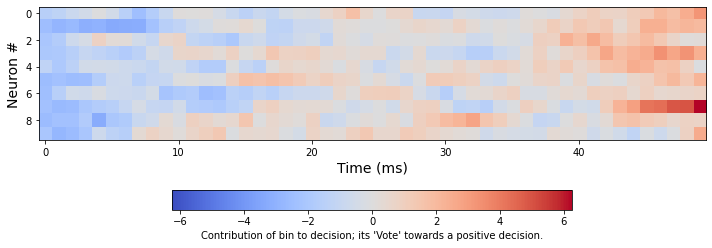

Fold 1 of 5
   Validation accuracy of 0.88
   True test set accuracy of 0.9


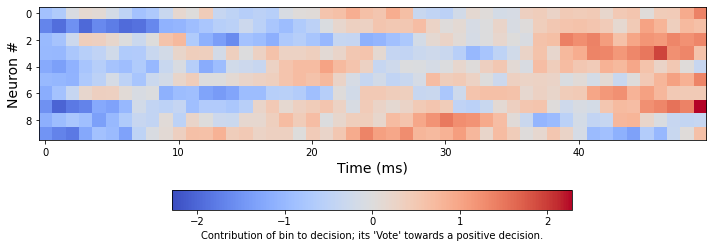

Fold 2 of 5
   Validation accuracy of 0.96
   True test set accuracy of 0.896


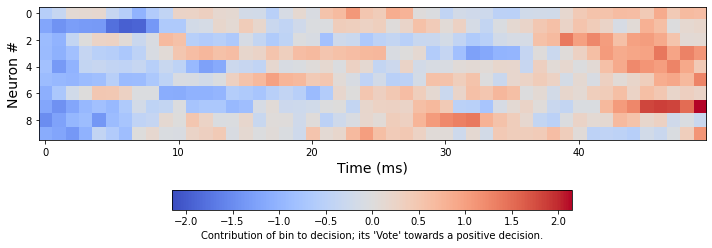

Fold 3 of 5
   Validation accuracy of 0.8
   True test set accuracy of 0.884


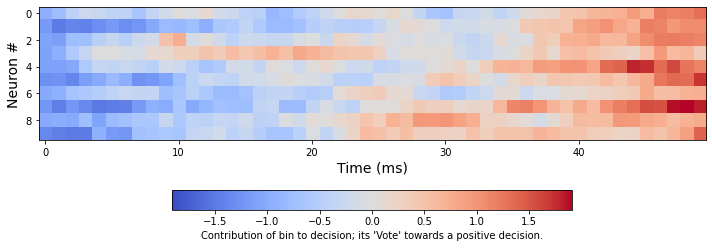

Fold 4 of 5
   Validation accuracy of 0.8
   True test set accuracy of 0.884


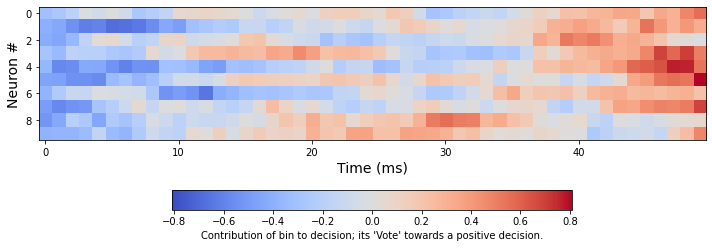

Mean validation accuracy: 0.8639999999999999


In [20]:
(training_sets, training_Ys), (val_sets, val_Ys) = get_test_train_splits(X, decisions)

scores = []

# Iterate through the k=5 folds
for fold in range(5):
  print("Fold {} of 5".format(fold))
  
  training_X = training_sets[fold]
  training_Y = training_Ys[fold]
  
  validation_X = val_sets[fold]
  validation_Y = val_Ys[fold]
  
  # Redefine the logistic regression model. (important to do this inside the loop)
  this_model = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs', max_iter = 1000)
  
  # Now fit on the training data
  this_model.fit(training_X, training_Y)
  
  # score on the validation data
  this_accuracy = this_model.score(validation_X, validation_Y)
  
  scores.append(this_accuracy)
  
  # score on the new dataset (new_X, new_decisions from above)
  accuracy_on_test_data = this_model.score(new_X, new_decisions)
  
  print("   Validation accuracy of {}".format( this_accuracy ))
  print("   True test set accuracy of {}".format( accuracy_on_test_data ))
  plot_coefs(this_model)
  
print("Mean validation accuracy: {}".format(np.mean(scores)))

How close is the validation accuracy to the test set accuracy? 

How much did using 80% of the data affect the test set accuracy?

## 3. Regularization

Here we'll apply regularization, as talked about in the lecture.


#### Exercise 3.1

Go to the [scikit-learn docs](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) and decide which form of regularization you would like to use with logistic regression.

#### Exercise 3.2

Copy and paste the cell from _Excercise 2_, but this time change the `penalty` flag in the `LogisticRegression` call to the form of regularization you chose. 


First all other default parameters. Then set `C=1e-6` and see what happens.


Fold 0 of 5
   Validation accuracy of 0.9
   True test set accuracy of 0.828


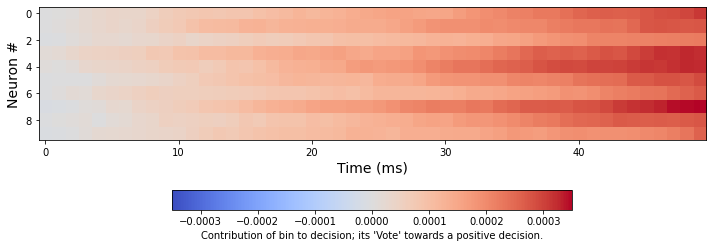

Fold 1 of 5
   Validation accuracy of 0.82
   True test set accuracy of 0.836


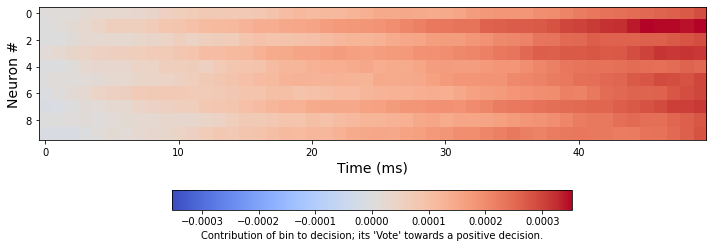

Fold 2 of 5
   Validation accuracy of 0.74
   True test set accuracy of 0.792


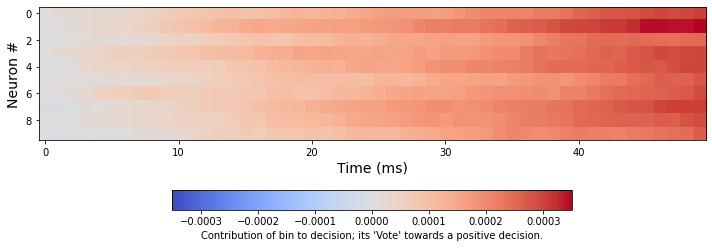

Fold 3 of 5
   Validation accuracy of 0.7
   True test set accuracy of 0.708


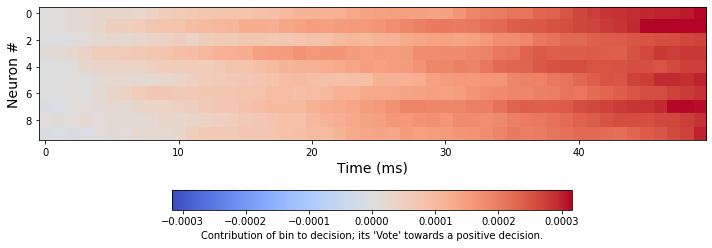

Fold 4 of 5
   Validation accuracy of 0.56
   True test set accuracy of 0.62


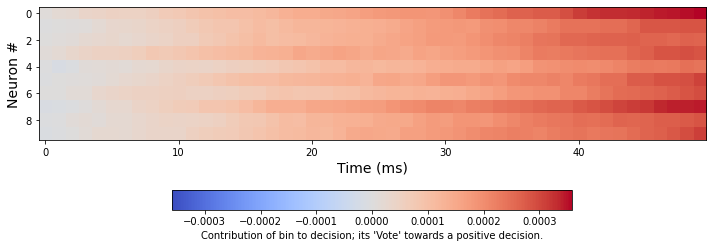

Mean validation accuracy: 0.744


In [34]:
# copy, paste, and regularize Exercise 2
(training_sets, training_Ys), (val_sets, val_Ys) = get_test_train_splits(X, decisions)

scores = []

# Iterate through the k=5 folds
for fold in range(5):
  print("Fold {} of 5".format(fold))
  
  training_X = training_sets[fold]
  training_Y = training_Ys[fold]
  
  validation_X = val_sets[fold]
  validation_Y = val_Ys[fold]
  
  # Redefine the logistic regression model. (important to do this inside the loop)
  this_model = linear_model.LogisticRegression(penalty='l2', C=1e-6, max_iter = 1000)
  
  # Now fit on the training data
  this_model.fit(training_X, training_Y)
  
  # score on the validation data
  this_accuracy = this_model.score(validation_X, validation_Y)
  
  scores.append(this_accuracy)
  
  # score on the new dataset (new_X, new_decisions from above)
  accuracy_on_test_data = this_model.score(new_X, new_decisions)
  
  print("   Validation accuracy of {}".format( this_accuracy ))
  print("   True test set accuracy of {}".format( accuracy_on_test_data ))
  plot_coefs(this_model)
  
print("Mean validation accuracy: {}".format(np.mean(scores)))

#### Exercise 3.3: Choose the best regularization penalty

Let's automate the above process so that we can choose the best performing value of `C`.

First, write a function (largely copy and paste from the last exercise) that returns the mean validation accuracy for
an arbitrary value of `C`.

In [46]:
# First complete this function that takes data (e.g. X) 
# and a model, and returns the average validation accuracy from 5-fold CV
# (Largely copy and paste from above, but deleting print statements)
def get_kfold_validation_score(data, decisions, C):
    (training_sets, training_Ys), (val_sets, val_Ys) = get_test_train_splits(X, decisions)
    scores = []
    # Iterate through the k=5 folds
    for fold in range(5):
        training_X = training_sets[fold]
        training_Y = training_Ys[fold]
        validation_X = val_sets[fold]
        validation_Y = val_Ys[fold]
        # Redefine the logistic regression model. (important to do this inside the loop)
        this_model = linear_model.LogisticRegression(penalty='l2', C=C, max_iter = 1000)
        # Now fit on the training data
        this_model.fit(training_X, training_Y)
        # score on the validation data
        this_accuracy = this_model.score(validation_X, validation_Y)
        scores.append(this_accuracy)
        # score on the new dataset (new_X, new_decisions from above)
        accuracy_on_test_data = this_model.score(new_X, new_decisions)
        mean_validation_accuracy = np.array(scores).mean()
    return mean_validation_accuracy

Now let's create a loop for various values of `C` and see what's the best.


In [47]:
# decide on a logarithmic schedule of Cs. 
Cs_to_test = np.logspace(-6, 3, 30)

validation_accuracy_vs_C = []
for C in Cs_to_test:
  
    # get the mean score on k-fold cross-validation using your function above
    mean_validation_accuracy = get_kfold_validation_score(X, decisions, C)
    
    validation_accuracy_vs_C.append(mean_validation_accuracy)
  
  

C:\Users\neuro\anaconda3\envs\ndecod\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\neuro\anaconda3\envs\ndecod\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

(0.8, 1.0)

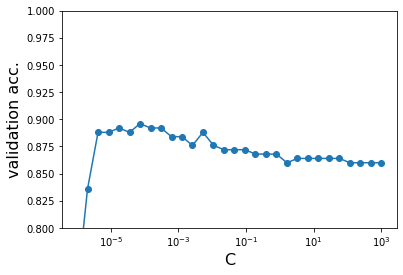

In [48]:
# Now plot the lists you just made. (Just run this.)
plt.semilogx(Cs_to_test, validation_accuracy_vs_C,"o-")
plt.xlabel("C",fontsize=16)
plt.ylabel("validation acc.",fontsize=16)
plt.ylim([.8,1])

In [52]:
Cmax_sub = np.array(validation_accuracy_vs_C).argmax()
optimal_C = Cs_to_test[Cmax_sub]
log_reg = linear_model.LogisticRegression(penalty='l2', C=optimal_C, max_iter=5000)
log_reg.fit(training_data, training_decisions)

print("R2 train:", log_reg.score(training_data, training_decisions))
print("R2 validation:", log_reg.score(validation_data, validation_decisions))
print("R2 test:", log_reg.score(new_X, new_decisions))

R2 train: 0.915
R2 validation: 0.9
R2 test: 0.928


## 4. Applying recurrent neural networks

This section is going to be a bit of an introduction to our [python package for neural decoding](https://github.com/KordingLab/Neural_Decoding).

First let's install the package. This will also install all the dependencies we need.

In [53]:
!pip install Neural-Decoding --upgrade

  Using cached Neural_Decoding-0.1.5-py3-none-any.whl (18 kB)
  Attempting uninstall: Neural-Decoding
    Found existing installation: Neural-Decoding 0.1.2.dev0
    Uninstalling Neural-Decoding-0.1.2.dev0:
      Successfully uninstalled Neural-Decoding-0.1.2.dev0


In [57]:
from Neural_Decoding import decoders

import warnings
warnings.filterwarnings('ignore')

Let's take a look at the documentation of the decoder we'll use.

In [58]:
# Run me
?decoders.SimpleRNNClassification

In [59]:
?decoders.SimpleRNNClassification.fit

You'll notice that the shape of the training inputs is now **3-dimensional**. This is because we can now explitly model the effect of time! Hooray! 

Recall that recurrent neural networks contain a "hidden state". The way this decoder works is that it reads all the neural activities in at the first time bin (out of `n_time_bins`) and then updates its hidden state accordingly. The value of this hidden state informs how the hidden state will evolve over time in each trial. After the hidden state updates `n_time_bin` times, it outputs its prediction for the animal's choice.


Lets apply this classifier to the data.

In [0]:
# lets re-split our original 3-dimensional trials/neurons/time input data.
split = int(n_trials*4/5)

training_data = neural_recordings[:split]
validation_data = neural_recordings[split:]

training_decisions = decisions[:split]
validation_decisions = decisions[split:]

training_data = np.swapaxes(training_data, 1, 2)
validation_data = np.swapaxes(validation_data, 1, 2)

print("Training input data is of shape", training_data.shape)
print("Validation input data is of shape", validation_data.shape)


In [0]:

# first we instantiate the decoder
my_RNN_classifier = decoders.SimpleRNNClassification(units = 50,
                                                    dropout = 0,
                                                    num_epochs =250,
                                                    verbose = 1)

In [0]:
# now we fit to our training data, like before
my_RNN_classifier.fit(training_data, training_decisions)

In [0]:
# predict on the validation data

predictions = my_RNN_classifier.predict(validation_data)
predictions

##### Excercise 4.0

Get the percentage of the predictions that were made correctly.

This is not as quite as good as logistic regression yet. There are a lot of parameters to choose for RNNs, and we haven't tried that yet.


#### Looking inside the model

Within the `my_RNN_classifier` object you just fit, there is an actual Keras model. We can look at it, change its parameters, and use Keras methods.

In [0]:
# Put the cursor after model, and press tab to see the methods we can call
my_RNN_classifier.model.

In [0]:
# for example, we can use Keras's in-built method for calculating accuracy
from keras.utils import np_utils
acc = my_RNN_classifier.model.test_on_batch(validation_data, 
                                      np_utils.to_categorical(validation_decisions))
print("Accuracy is {} %".format(100*acc[1]))

#### Excercise 4.1: Tuning the RNN

Train an RNN decoder again, but this time use 1000 hidden units instead of 50.

## 5. Compare many methods on actual neural data

### Preliminaries

**STOP** Make sure you're running a **GPU runtime** for this section. (Runtime -> Change runtime type). Otherwise running the RNNs will take forever.

First we need to download the data. I created a script to download and process the Steinmetz data into the format we need. Since the processing script takes about 15 minutes, we'll skip that step, and you can just download the processed data from my Google Drive.

This dataset is specifically `Cori_2016-12-18`. If you're interested in loading a different session, I've copied my downloading and preprocessing script in the bottom of this notebook and you can run it right here.

In [0]:
!pip install googledrivedownloader

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1W3TwEtC0Z6Qmbfuz8_AWRiQHfuDb9FIS',
                                    dest_path='./Binned_data.zip',
                                    unzip=True)


In [0]:
binned_spikes = np.load('binned_spikes.npy')
choices = np.load('choices.npy')+1


### Predicting choices from neural population recordings

We're going to try to predict the mouse's choices from the neuropixel recordings in the 1 second preceeding each choice. `binned_spikes.npy` is a numpy array containing the binned spike rates, and `choices.npy` contains the animal's choices. 

There are 228 trials, 1089 neurons, and 50 bins per trial (for a time of 20ms per bin).

This is not a great situation for machine learning. As a rule of thumb, we would like more trials than datapoints per trial. (If doing this for realz, would suggest running PCA on this data and using the top components as inputs). But, it's what we got, so here goes!

#### Exercise 5.0

Print out the shape of `binned_spikes` and `choices`. Also print out the first 10 choices.



In [0]:

print(binned_spikes.shape, choices.shape)
print(choices[:10])

You'll notice that `choices` takes values 0, 1, and 2. We're going to try to decode this.

#### Excercise 5.1

Split this data into test and validation splits.

(We'll skip the final testing phase in this exercise. In reality, make sure to do cross-validation and use both validation and testing data.)

In [0]:
# make training and validation data
# Use an 80/20 split.|
split = 

training_spikes = 
validation_spikes = 

training_choices = 
validation_choices =

##### A fitting demo.

This is basically what we did above, but with actual data.

In [0]:

my_RNN_classifier = decoders.SimpleRNNClassification(units = 100,
                                                    dropout = 0,
                                                    num_epochs =10,
                                                    verbose = 1)

my_RNN_classifier.fit(training_spikes, training_choices)


predictions = my_RNN_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))

print("\n validation accuracy: {} %".format(100*accuracy))


Note that the train accuracy reached about 100% in these 10 epochs, but the validation accuracy is quite low. Sounds like overfitting! We might want to try some regularization, like dropout.

### Excercise 5.1

Fit each of the following decoders:

1.   A Gated Recurrent Unit (`decoders.GRUClassification`)
2.   An LSTM (`decoders.LSTMClassification`)
3.   Gradient boosted trees (XGBoost) (`decoders.XGBoostClassification`)





In [0]:
# GRU



In [0]:
#LSTM


In [0]:
# XGBoost

# XGBoost is powerful but does not model time dependencies.
# Like for the logistic regression above, we have to flatten
# the inputs into shape (n_trials, n_neurons x n_time_bins)

flat_train_data = np.reshape(training_spikes, (len(training_spikes),-1))
flat_val_data = np.reshape(validation_spikes, (len(validation_spikes),-1))


# now train it like above




### Extra credit exercise 1: reduce the dimension of data with PCA

Create an instance of PCA (loading the module from scikit-learn). Then, fit it on your training data. Then transform both the validation and train data. (Note that we don't fit the PCA using train data.)

You can either reduce the dimension across neurons only, preserving temporal structure, or decide to reduce across all dimensions.

Does validation accuracy improve?

### Extra credit exercise 2: Set up a script to perform k-fold CV

Using your favorite methods (e.g. scikit learn) or the script we wrote above, create a method to perform 5-fold cross-validation on the Neuropixels data. The function should take parameters to create a model as input, and it should output the average validation accuracy across the 5 validation sets. 

### Extra credit exercise 3: find the best decoder

Search across methods and hyperparameters for the best decoder. Try hyperopt, or random searches.

If you're fancy and have lots of compute time, maybe try automated ML. (e.g. autosklearn)


## Appendix: downloading a Neuropixels session and processing

This will take about 30 seconds to download the ~600M of data into your working folder, and 10 minutes to run the script.

In [0]:
session = "Cori_2016-12-18/"

!wget -np -r -nv http://data.cortexlab.net/taskData/$session
!mv data.cortexlab.net/taskData/ .

Now we'll extract this data into Python in the form of a dictionary.

In [0]:
from tqdm import tqdm as tqdm

def load_data(session):
    """Takes a session in relative path ./taskData and loads it as a dictionary."""
    files = !ls taskData/$session/*.npy
    all_files = {}
    for file in files:
        filename = file.split("/")[1][:-4]
        all_files[filename] = np.load(file)
    return all_files
  
def count_neurons(time_interval, all_files):
    """In this time interval, return the neurons with nonzero spikes, and how many
    
    Returns (ids, counts)
    """
    
    
    t1,t2 = time_interval
    
    trial_spikes = all_files['spikes.times']

    interval = (trial_spikes > t1) & (trial_spikes < t2)

    trial_spikes = trial_spikes[interval]
    ids = all_files['spikes.clusters'][interval]
    
    # ids has all the info we need
    return np.unique(ids, return_counts = True)
    
    


def bin_into_array(all_files, time_before_response=1, n_bins = 50):
    
    ids = all_files['spikes.clusters']
    idList = np.unique(ids)
    
    n_trials = len(all_files['trials.response_choice'])
    n_neurons = len(idList)
    
    choices = np.reshape(all_files['trials.response_choice'],-1)
    data = np.zeros((n_trials, n_neurons, n_bins))
    
    time_resolution = time_before_response/ float(n_bins)
    
    for trial in tqdm(range(n_trials)):
        end_time = all_files['trials.response_times'][trial]
        start_time = end_time - time_before_response
        
        data.trial
        
        for b in range(n_bins):
        
            which_neurons, n_spikes = count_neurons((start_time + b*time_resolution,
                                            start_time + (b+1)*time_resolution),
                                          all_files)
            
            data[trial,which_neurons,b] = n_spikes
            
    return data, choices


In [0]:
session = "Cori_2016-12-18"
all_files = load_data(session)
data, choices = bin_into_array(all_files)

In [0]:
#clean up the data we aren't using
!rm -r data.cortexlab.net/